In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, make_scorer, roc_curve, roc_auc_score
from scipy.stats import randint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import os
import joblib

C:\Users\ejdoj\churn-prediction-challenge\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
caminho_arquivo = os.path.join('..', 'data', '02_processed', 'telco_customer_churn_processed.csv')

# Carrega o DataFrame processado
df_limpo = pd.read_csv(caminho_arquivo, sep = ',')

# Exibe as primeiras linhas e as informações para confirmar o carregamento
print("DataFrame limpo carregado com sucesso:")
df_limpo.head()

DataFrame limpo carregado com sucesso:


,Dependents,Partner,PhoneService,PaperlessBilling,gender,Contract,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,StreamingMovies_No,...,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges_escalado,TotalCharges_padronizado,SeniorCitizen,Churn
0,0,1,1,1,0,0,0,1,0,1,...,0,0,0,0,1,0.847222,0.627839,1.225382,0,0
1,0,1,0,1,1,0,1,0,0,1,...,0,0,0,1,0,0.111111,0.364455,-1.274232,0,1
2,0,1,1,0,1,2,1,0,0,1,...,0,0,0,0,1,0.569444,0.776043,0.856278,0,1
3,0,1,1,1,1,0,1,0,0,0,...,0,1,0,0,0,0.638889,0.903733,1.239049,1,0
4,0,1,1,1,0,2,1,0,0,1,...,0,0,1,0,0,0.458333,0.433604,0.013096,0,0


Por que o Recall é crucial?
Vamos analisar o custo dos erros para a empresa de telecomunicações:

Falso Negativo (FN): O modelo prevê que o cliente não vai cancelar, mas ele acaba cancelando.
Custo: A empresa perde o cliente e a receita que ele geraria. Este é um erro muito caro, pois significa que a equipe de retenção não agiu sobre um cliente que precisava de atenção.




Falso Positivo (FP): O modelo prevê que o cliente vai cancelar, mas ele não cancela.
Custo: A empresa investe recursos em uma campanha de retenção (e-mail, desconto, ligação) para um cliente que já estava satisfeito. Isso é um desperdício de recursos, mas o custo é geralmente menor do que o de perder um cliente.
O Recall mede a capacidade do modelo de encontrar todos os clientes que realmente cancelaram. Um alto Recall significa que o modelo é excelente em identificar os "verdadeiros churners", minimizando os Falsos Negativos.

In [3]:
# 1. Separar features (X) e a variável alvo (y)
X = df_limpo.drop(columns='Churn')
y = df_limpo['Churn']

print("Dimensão das features (X):", X.shape)
print("Dimensão da variável alvo (y):", y.shape)

# 2. Dividir os dados em conjuntos de treino e teste
# 80% para treino e 20% para teste, com um random_state para reprodutibilidade
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify é crucial para manter a proporção das classes

print("\nDados divididos em conjuntos de treino e teste:")
print(f"X_treino: {X_treino.shape}")
print(f"y_treino: {y_treino.shape}")
print(f"X_teste: {X_teste.shape}")
print(f"y_teste: {y_teste.shape}")

# 3. Criar e treinar o modelo de Regressão Logística
# AQUI ESTÁ A MELHORIA: Usamos class_weight='balanced' para focar no recall da classe minoritária ('Yes')
modelo_lr = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
modelo_lr.fit(X_treino, y_treino)

print("\nModelo de Regressão Logística treinado com sucesso!")

# 4. Fazer previsões
y_pred_treino = modelo_lr.predict(X_treino)
y_pred_teste = modelo_lr.predict(X_teste)

# 5. Avaliar o desempenho do modelo nos conjuntos de TREINO e TESTE
print("\n--- Avaliação no Conjunto de TREINO (para verificar Overfitting) ---")
print("Relatório de Classificação (TREINO):")
print(classification_report(y_treino, y_pred_treino))
recall_treino = recall_score(y_treino, y_pred_treino, pos_label=1)
print(f"Recall da classe 'Yes' (Churn) no TREINO: {recall_treino:.4f}")

print("\n--- Avaliação no Conjunto de TESTE (desempenho em dados novos) ---")
print("Relatório de Classificação (TESTE):")
print(classification_report(y_teste, y_pred_teste))
recall_teste = recall_score(y_teste, y_pred_teste, pos_label=1)
print(f"Recall da classe 'Yes' (Churn) no TESTE: {recall_teste:.4f}")

Dimensão das features (X): (7043, 38)
Dimensão da variável alvo (y): (7043,)

Dados divididos em conjuntos de treino e teste:
X_treino: (5634, 38)
y_treino: (5634,)
X_teste: (1409, 38)
y_teste: (1409,)

Modelo de Regressão Logística treinado com sucesso!

--- Avaliação no Conjunto de TREINO (para verificar Overfitting) ---
Relatório de Classificação (TREINO):
              precision    recall  f1-score   support

           0       0.77      0.47      0.59      3653
           1       0.43      0.75      0.55      1981

    accuracy                           0.57      5634
   macro avg       0.60      0.61      0.57      5634
weighted avg       0.65      0.57      0.57      5634

Recall da classe 'Yes' (Churn) no TREINO: 0.7476

--- Avaliação no Conjunto de TESTE (desempenho em dados novos) ---
Relatório de Classificação (TESTE):
              precision    recall  f1-score   support

           0       0.76      0.45      0.56       914
           1       0.42      0.74      0.54      

Agora vamos usar otimização de hiperparâmetros para melhorar o recall

In [4]:
# 1. Definir a grade de parâmetros para a busca
# 'C': Inverso da força de regularização (valores menores = regularização mais forte).
# 'penalty': O tipo de regularização. 'l1' e 'l2' são compatíveis com o solver 'liblinear'.
param_grid = {
    'C': np.logspace(-4, 4, 20), # Gera 20 valores logaritmicamente espaçados entre 1e-4 e 1e4
    'penalty': ['l1', 'l2']
}

# 2. Definir o modelo base com class_weight='balanced'
# Manteremos 'class_weight' fixo, pois vimos que é crucial para o recall.
# O solver 'liblinear' é escolhido por suportar tanto penalidades 'l1' quanto 'l2'.
modelo_base = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)

# 3. Definir a métrica de scoring para a otimização
# Usaremos o Recall da classe positiva ('Yes' ou 1) como a métrica principal para a busca
scorer_recall = make_scorer(recall_score, pos_label=1)

# 4. Configurar a busca em grade com validação cruzada estratificada (5 folds)
# StratifiedKFold garante que a proporção das classes seja mantida em cada fold
cv_estratificado = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    scoring=scorer_recall, # Otimiza diretamente para o Recall da classe 'Yes'
    cv=cv_estratificado,
    n_jobs=-1, # Usa todos os núcleos da CPU para acelerar o processo
    verbose=2 # Exibe o progresso da busca
)

# 5. Executar a busca em grade no conjunto de treino
print("Iniciando a busca em grade para otimização de hiperparâmetros...")
grid_search.fit(X_treino, y_treino)

# 6. Exibir os melhores parâmetros e a melhor pontuação
print("\nBusca em grade concluída!")
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor Recall (média da validação cruzada): {grid_search.best_score_:.4f}")

# 7. Avaliar o melhor modelo no conjunto de TREINO e TESTE
melhor_modelo = grid_search.best_estimator_

# Fazer previsões nos conjuntos de treino e teste
y_pred_treino = melhor_modelo.predict(X_treino)
y_pred_teste = melhor_modelo.predict(X_teste)

# --- Avaliação no Conjunto de TREINO (para verificar Overfitting) ---
print("\n--- Avaliação do Melhor Modelo no Conjunto de TREINO ---")
print("Relatório de Classificação (TREINO):")
print(classification_report(y_treino, y_pred_treino))
recall_treino = recall_score(y_treino, y_pred_treino, pos_label=1)
print(f"Recall da classe 'Yes' (Churn) no TREINO: {recall_treino:.4f}")

# --- Avaliação no Conjunto de TESTE (desempenho em dados novos) ---
print("\n--- Avaliação do Melhor Modelo no Conjunto de TESTE ---")
print("Relatório de Classificação (TESTE):")
print(classification_report(y_teste, y_pred_teste))
recall_teste = recall_score(y_teste, y_pred_teste, pos_label=1)
print(f"Recall da classe 'Yes' (Churn) no conjunto de teste: {recall_teste:.4f}")

Iniciando a busca em grade para otimização de hiperparâmetros...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Busca em grade concluída!
Melhores parâmetros encontrados: {'C': 0.08858667904100823, 'penalty': 'l1'}
Melhor Recall (média da validação cruzada): 0.7708

--- Avaliação do Melhor Modelo no Conjunto de TREINO ---
Relatório de Classificação (TREINO):
              precision    recall  f1-score   support

           0       0.79      0.44      0.57      3653
           1       0.43      0.78      0.55      1981

    accuracy                           0.56      5634
   macro avg       0.61      0.61      0.56      5634
weighted avg       0.66      0.56      0.56      5634

Recall da classe 'Yes' (Churn) no TREINO: 0.7769

--- Avaliação do Melhor Modelo no Conjunto de TESTE ---
Relatório de Classificação (TESTE):
              precision    recall  f1-score   support

           0       0.77      0.42      0.55       914
           1       0.42      0.77      0.54  

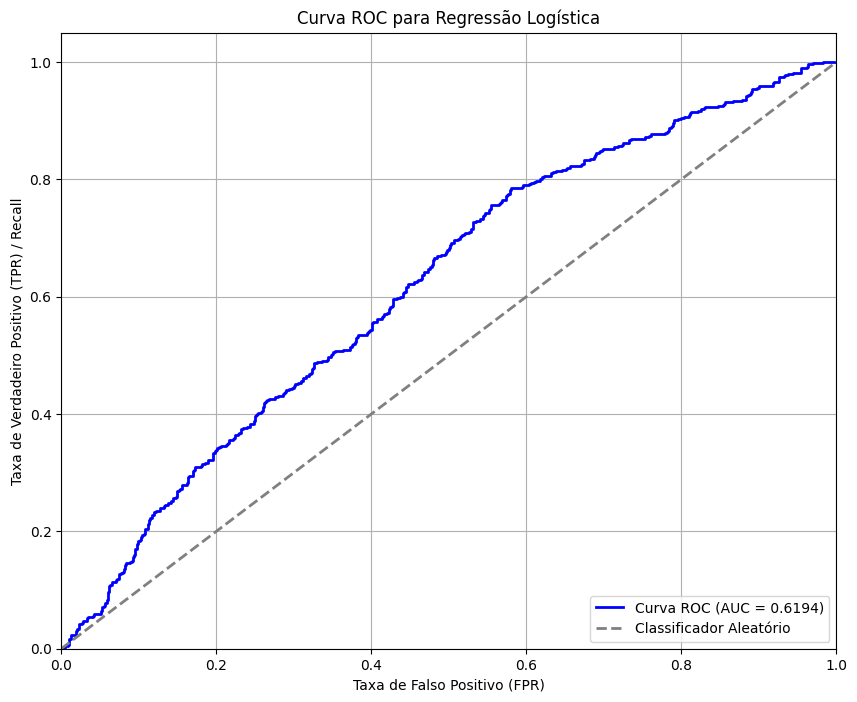

Pontuação AUC-ROC: 0.6194


In [5]:
# 4. Obter as probabilidades de previsão para a classe positiva (Churn=1)
# A curva ROC usa as probabilidades, não as previsões binárias (0 ou 1)
y_prob = melhor_modelo.predict_proba(X_teste)[:, 1]

# 5. Calcular a curva ROC e a área sob a curva (AUC)
fpr, tpr, thresholds = roc_curve(y_teste, y_prob)
auc_score = roc_auc_score(y_teste, y_prob)

# 6. Criar e plotar o gráfico da curva ROC
# Em um notebook, você usaria plt.show() para exibir o gráfico diretamente.
# Neste ambiente, o gráfico é salvo em um arquivo temporário para ser exibido.
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Classificador Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR) / Recall')
plt.title('Curva ROC para Regressão Logística')
plt.legend(loc='lower right')
plt.grid(True)

# Exibir o gráfico diretamente no notebook
plt.show()

# Fechar o plot para liberar a memória
plt.close()

# Imprimir a métrica no terminal
print(f"Pontuação AUC-ROC: {auc_score:.4f}")

In [6]:
# Define o diretório de destino para os dados de relatório
pasta_destino = os.path.join('..', 'reports', 'dashboard_data')

# Cria o diretório se ele não existir
os.makedirs(pasta_destino, exist_ok=True)
print(f"Diretório de destino criado/verificado: {pasta_destino}")

# Cria um DataFrame com os dados da curva
df_roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds})
caminho_roc = os.path.join(pasta_destino, 'roc_curve_data.csv')
df_roc_data.to_csv(caminho_roc, index=False)
print(f"Dados da Curva ROC salvos em: {caminho_roc}")

Diretório de destino criado/verificado: ..\reports\dashboard_data
Dados da Curva ROC salvos em: ..\reports\dashboard_data\roc_curve_data.csv


Em resumo, não há overfitting, visto que o resultado de treino e parecido com o de teste. E temos a conclusão de que o modelo identifica 77% dos clientes que desejam abandonar o serviço!

Agora vamos tentar o modelo floresta aleatória!

In [7]:
# 1. Criar e treinar o modelo de Floresta Aleatória (Random Forest)
# Usamos o class_weight='balanced' para focar no recall da classe minoritária, assim como na Regressão Logística.
# n_estimators=100 é um bom valor padrão para o número de árvores na floresta.
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
modelo_rf.fit(X_treino, y_treino)

print("\nModelo de Floresta Aleatória (Random Forest) treinado com sucesso!")

# 2. Fazer previsões nos conjuntos de treino e teste
y_pred_treino = modelo_rf.predict(X_treino)
y_pred_teste = modelo_rf.predict(X_teste)

# 3. Avaliar o desempenho do modelo nos conjuntos de TREINO e TESTE
print("\n--- Avaliação no Conjunto de TREINO (para verificar Overfitting) ---")
print("Relatório de Classificação (TREINO):")
print(classification_report(y_treino, y_pred_treino))
recall_treino = recall_score(y_treino, y_pred_treino, pos_label=1)
print(f"Recall da classe 'Yes' (Churn) no TREINO: {recall_treino:.4f}")

print("\n--- Avaliação no Conjunto de TESTE (desempenho em dados novos) ---")
print("Relatório de Classificação (TESTE):")
print(classification_report(y_teste, y_pred_teste))
recall_teste = recall_score(y_teste, y_pred_teste, pos_label=1)
print(f"Recall da classe 'Yes' (Churn) no TESTE: {recall_teste:.4f}")


Modelo de Floresta Aleatória (Random Forest) treinado com sucesso!

--- Avaliação no Conjunto de TREINO (para verificar Overfitting) ---
Relatório de Classificação (TREINO):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3653
           1       1.00      1.00      1.00      1981

    accuracy                           1.00      5634
   macro avg       1.00      1.00      1.00      5634
weighted avg       1.00      1.00      1.00      5634

Recall da classe 'Yes' (Churn) no TREINO: 1.0000

--- Avaliação no Conjunto de TESTE (desempenho em dados novos) ---
Relatório de Classificação (TESTE):
              precision    recall  f1-score   support

           0       0.66      0.91      0.77       914
           1       0.47      0.14      0.21       495

    accuracy                           0.64      1409
   macro avg       0.57      0.53      0.49      1409
weighted avg       0.59      0.64      0.57      1409

Recall da classe '

In [8]:
# 1. Definir a grade de parâmetros para a busca aleatória
# Definiremos distribuições de onde os parâmetros serão sorteados.
param_dist = {
    'n_estimators': randint(100, 500),    # Número de árvores na floresta (entre 100 e 500)
    'max_depth': randint(10, 50),         # Profundidade máxima da árvore (importante para controlar overfitting)
    'min_samples_split': randint(2, 20),  # Mínimo de amostras para dividir um nó
    'min_samples_leaf': randint(1, 10),   # Mínimo de amostras em uma folha (também importante para evitar overfitting)
    'max_features': ['sqrt', 'log2', 1.0] # Número de features para considerar em cada divisão
}

# 2. Definir o modelo base com class_weight='balanced'
# Manteremos 'class_weight' fixo para manter o foco no recall.
modelo_base_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 3. Definir a métrica de scoring para a otimização (Recall da classe 'Yes')
scorer_recall = make_scorer(recall_score, pos_label=1)

# 4. Configurar a busca aleatória com validação cruzada estratificada (5 folds)
cv_estratificado = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=modelo_base_rf,
    param_distributions=param_dist,
    n_iter=100, # Número de combinações de parâmetros a serem testadas (aumentei para 100 para uma busca mais completa)
    scoring=scorer_recall, # Otimiza para o Recall da classe 'Yes'
    cv=cv_estratificado,
    n_jobs=-1, # Usa todos os núcleos da CPU para acelerar
    verbose=2, # Exibe o progresso da busca
    random_state=42
)

# 5. Executar a busca no conjunto de treino
print("Iniciando a busca aleatória para otimização de hiperparâmetros...")
random_search.fit(X_treino, y_treino)

# 6. Exibir os melhores parâmetros e a melhor pontuação
print("\nBusca aleatória concluída!")
print(f"Melhores parâmetros encontrados: {random_search.best_params_}")
print(f"Melhor Recall (média da validação cruzada): {random_search.best_score_:.4f}")

# 7. Avaliar o melhor modelo no conjunto de teste
melhor_modelo_rf = random_search.best_estimator_
y_pred_otimizado = melhor_modelo_rf.predict(X_teste)

print("\n--- Avaliação do Melhor Modelo no Conjunto de Teste ---")
print("Relatório de Classificação:")
print(classification_report(y_teste, y_pred_otimizado))

recall_otimizado = recall_score(y_teste, y_pred_otimizado, pos_label=1)
print(f"Recall da classe 'Yes' (Churn) no conjunto de teste: {recall_otimizado:.4f}")

Iniciando a busca aleatória para otimização de hiperparâmetros...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Busca aleatória concluída!
Melhores parâmetros encontrados: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 188}
Melhor Recall (média da validação cruzada): 0.5598

--- Avaliação do Melhor Modelo no Conjunto de Teste ---
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       914
           1       0.43      0.61      0.50       495

    accuracy                           0.58      1409
   macro avg       0.58      0.58      0.57      1409
weighted avg       0.62      0.58      0.59      1409

Recall da classe 'Yes' (Churn) no conjunto de teste: 0.6121


In [9]:
# --- Salva o melhor modelo na pasta 'models' ---

# 1. Define o diretório de destino
pasta_destino = os.path.join('..', 'models')

# 2. Cria a pasta 'models' se ela não existir
os.makedirs(pasta_destino, exist_ok=True)

# 3. Define o caminho e nome do arquivo para o modelo
nome_arquivo = 'logistic_regression_best_model.pkl'
caminho_modelo = os.path.join(pasta_destino, nome_arquivo)

# 4. Salva o objeto do modelo usando joblib
joblib.dump(melhor_modelo, caminho_modelo)

print(f"Modelo de Regressão Logística otimizado salvo em: {caminho_modelo}")

Modelo de Regressão Logística otimizado salvo em: ..\models\logistic_regression_best_model.pkl


# Com a otimização de hiperparâmetros melhorou bastante o resultado da floresta aleatória, diminuindo o overfitting. Porém, o recall da regressão logística (77%) ainda é maior do que o da floresta aleatória (61%). 

# Portanto, a regressão logística é mais adequada para ter resultados melhores. Convém enfatizar, que "no mundo real", nem recall, precision ou accurary seriam o mais indicado. Eu iria calcular uma métrica customizada para otimizar os ganhos, com o melhor par de TPR e FPR como função de lucro. Afinal, é possível alterar o threshold e aumentar o recall (com o efeito colateral de aumentar a taxa de falsos positivos). Por padrão o threshold é 50%, mas podemos pensar em algo mais sofisticado dependendo da situação. E a partir das regras de negócio pode ser necessário mais do que um recall customizado para otimizar o lucro.

--- Coeficientes do Melhor Modelo de Regressão Logística (em ordem de influência) ---
Melhores parâmetros do GridSearch: {'C': 0.08858667904100823, 'penalty': 'l1'}
Intercepto (Bias): 0.0533

Top 10 Atributos Mais Influentes:
                              Atributo  Coeficiente
5                             Contract    -0.548758
32      PaymentMethod_Electronic check     0.432113
3                     PaperlessBilling     0.078226
0                           Dependents     0.046751
4                               gender     0.035942
8                   OnlineSecurity_Yes     0.034512
1                              Partner     0.028189
9                   StreamingMovies_No     0.027998
36            TotalCharges_padronizado    -0.021975
7   OnlineSecurity_No internet service    -0.020417


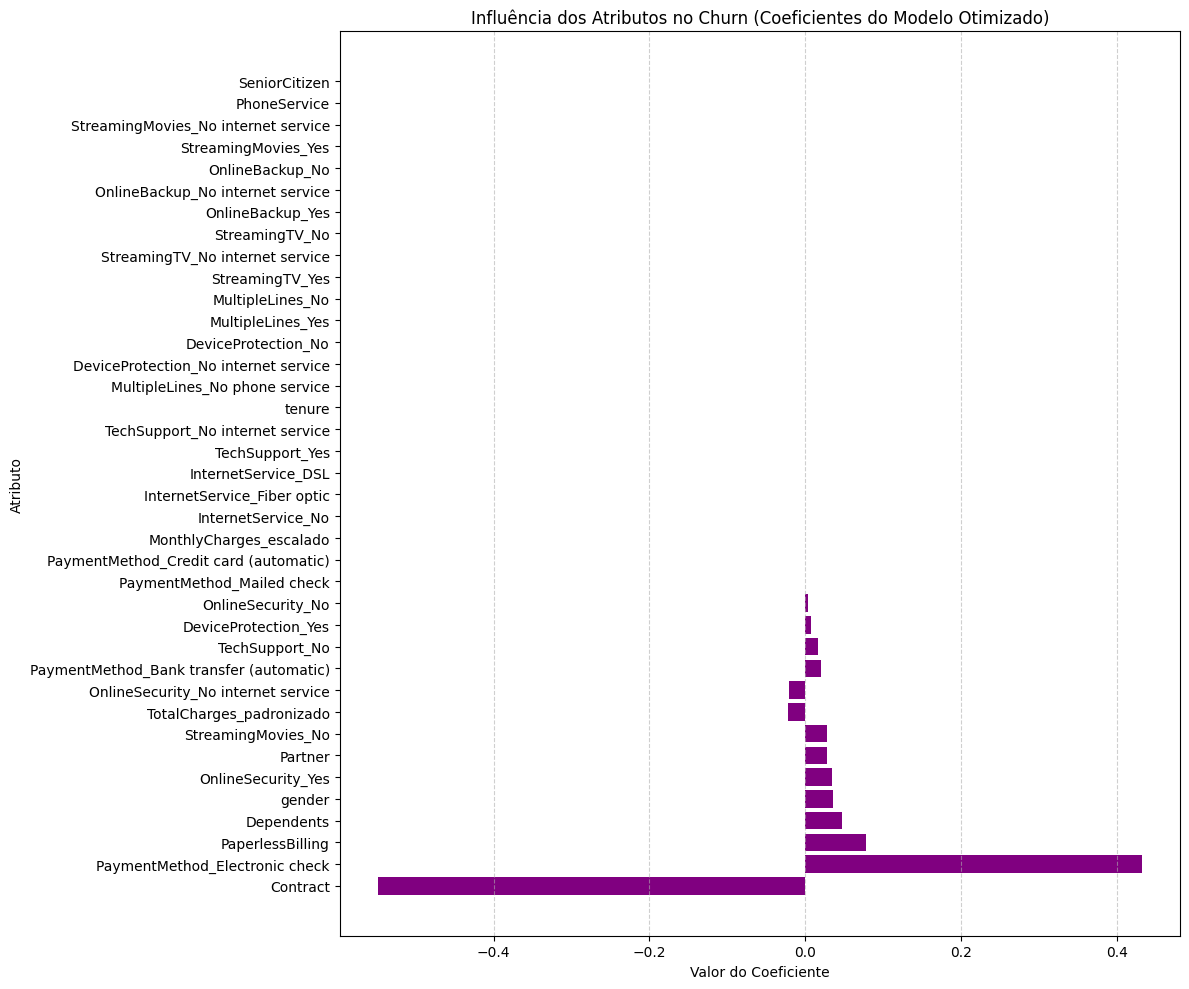

In [10]:
# Extrair os coeficientes e o intercepto do melhor modelo
coeficientes = melhor_modelo.coef_[0]
intercepto = melhor_modelo.intercept_[0]
features = X.columns

# Criar um DataFrame para visualizar os coeficientes
df_coeficientes = pd.DataFrame({
    'Atributo': features,
    'Coeficiente': coeficientes
})

# Ordenar os atributos pelo valor absoluto do coeficiente para ver os mais importantes
df_coeficientes_ordenado = df_coeficientes.reindex(df_coeficientes['Coeficiente'].abs().sort_values(ascending=False).index)

print("--- Coeficientes do Melhor Modelo de Regressão Logística (em ordem de influência) ---")
print(f"Melhores parâmetros do GridSearch: {grid_search.best_params_}")
print(f"Intercepto (Bias): {intercepto:.4f}")
print("\nTop 10 Atributos Mais Influentes:")
print(df_coeficientes_ordenado.head(10))

plt.figure(figsize=(12, 10))
plt.barh(df_coeficientes_ordenado['Atributo'], df_coeficientes_ordenado['Coeficiente'], color='purple')
plt.xlabel('Valor do Coeficiente')
plt.ylabel('Atributo')
plt.title('Influência dos Atributos no Churn (Coeficientes do Modelo Otimizado)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()
plt.close()


In [11]:
coeficientes = melhor_modelo.coef_[0]
features = X.columns

df_coeficientes = pd.DataFrame({'Atributo': features, 'Coeficiente': coeficientes})
# Ordena por valor absoluto para ter a ordem de importância
df_coeficientes_ordenado = df_coeficientes.reindex(df_coeficientes['Coeficiente'].abs().sort_values(ascending=False).index)

# Define o diretório de destino
pasta_destino = os.path.join('..', 'reports', 'dashboard_data')
os.makedirs(pasta_destino, exist_ok=True)

# Salva o DataFrame de coeficientes em um arquivo CSV
caminho_arquivo_coef = os.path.join(pasta_destino, 'logistic_regression_coefficients.csv')
df_coeficientes_ordenado.to_csv(caminho_arquivo_coef, index=False)

print(f"Dados de coeficientes do modelo salvos com sucesso em: {caminho_arquivo_coef}")

Dados de coeficientes do modelo salvos com sucesso em: ..\reports\dashboard_data\logistic_regression_coefficients.csv


# Como dito na EDA, contract e método de pagamento são os que mais influenciam no churn! Inclusive essa interpretabilidade dos resultados pode ajudar a compreender o que influencia e como tomar uma ação mais assertiva de benefícios para reter os clientes

## Contract (Coeficiente: -0.549): Continua sendo o fator mais influente e um forte preditor de retenção. Quanto maior a duração do contrato (1 ano, 2 anos), menor a probabilidade de o cliente cancelar. Clientes com contratos mais longos são muito mais leais.
## PaymentMethod_Electronic check (0.432): Este é o atributo que mais aumenta a probabilidade de churn. Clientes que utilizam essa forma de pagamento são o grupo de maior risco.
## PaperlessBilling (0.078): Clientes com faturamento digital (PaperlessBilling = Yes) têm uma probabilidade um pouco maior de cancelar.
## Dependents (0.047): Ter dependentes aumenta ligeiramente a probabilidade de churn.
## gender (0.036): O gênero do cliente também tem uma pequena influência na probabilidade de churn.
## OnlineSecurity_Yes (0.035): Um resultado interessante. Ter o serviço de segurança online parece aumentar a probabilidade de churn, o que pode indicar que esses clientes têm outras preocupações de serviço que levam ao cancelamento.
## Partner (0.028): Ter um parceiro aumenta a probabilidade de churn.
## StreamingMovies_No (0.028): Não ter o serviço de streaming de filmes aumenta a probabilidade de churn.
## TotalCharges_padronizado (-0.022): Clientes com um gasto total maior na empresa têm uma pequena probabilidade menor de churn, o que sugere que clientes que gastam mais são mais leais.
## OnlineSecurity_No internet service (-0.020): Esse coeficiente tem uma influência negativa muito pequena, indicando que o fato de o cliente não ter serviço de internet de forma geral reduz a chance de churn, comparado a quem tem um serviço de internet ruim.

Calculando valores SHAP... Isso pode levar alguns segundos.

Gerando o gráfico de resumo SHAP...


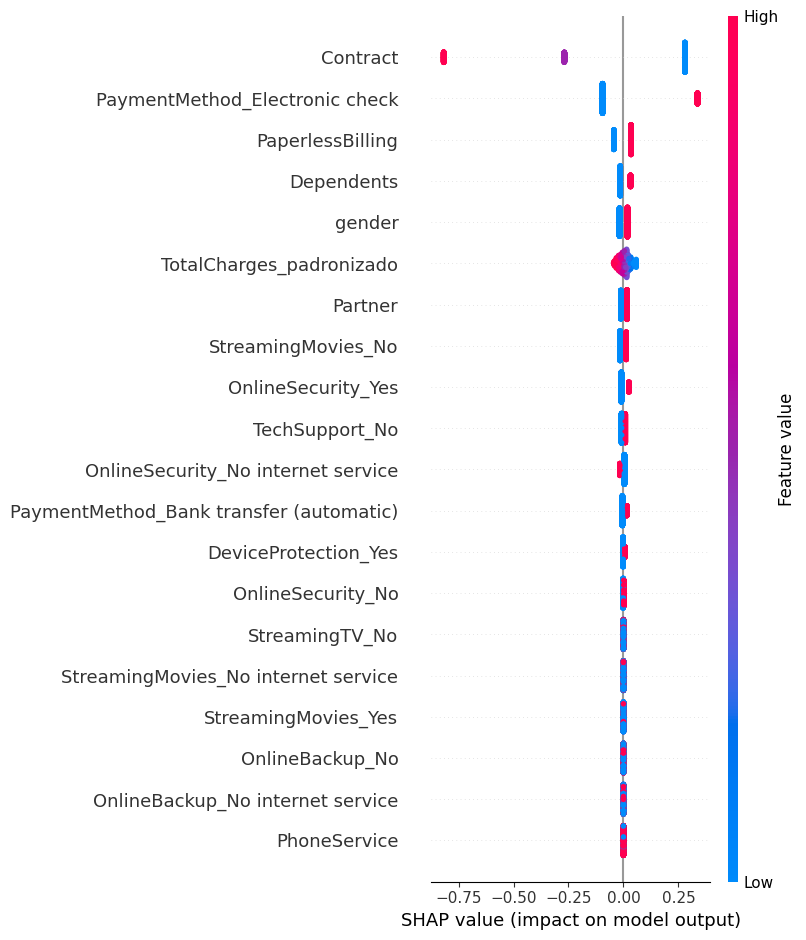

In [12]:
# 4.1. Criar um "explainer" SHAP para o modelo

explainer = shap.LinearExplainer(melhor_modelo, X_treino)

# 4.2. Calcular os valores SHAP para o conjunto de teste
print("Calculando valores SHAP... Isso pode levar alguns segundos.")
shap_values = explainer.shap_values(X_teste)

# 4.3. Criar o gráfico de resumo (Summary Plot)
# Este gráfico mostra a importância global dos atributos
# A função `summary_plot` já usa o `plt.show()` por padrão.
print("\nGerando o gráfico de resumo SHAP...")
shap.summary_plot(shap_values, X_teste, plot_type="dot", max_display=20) # max_display para mostrar mais features

## 1. Contract
Impacto no Churn: Este é o principal fator de retenção.
Interpretação do SHAP: A cor vermelha (valor alto, representando contratos de dois anos) e a cor intermediária (valor 1, contratos de um ano) estão concentradas no lado esquerdo do gráfico SHAP (impacto negativo). Isso significa que ter um contrato de longo prazo reduz drasticamente a probabilidade de churn. A cor azul (valor 0, contrato mensal) está concentrada no lado direito (impacto positivo), mostrando que este tipo de contrato é um forte impulsionador do cancelamento.
## 2. PaymentMethod_Electronic check
Impacto no Churn: Este é o principal fator de risco de churn.
Interpretação do SHAP: No gráfico, a presença do "cheque eletrônico" (valor alto) empurra a previsão fortemente para o churn. A ausência dessa forma de pagamento, por outro lado, tem pouca influência. A empresa deve focar ações de retenção em clientes que usam esse método de pagamento.
## 3. PaperlessBilling
Impacto no Churn: Aumenta a probabilidade de churn, embora com uma influência moderada.
Interpretação do SHAP: No gráfico, os pontos para clientes que utilizam o faturamento sem papel (Yes, cor vermelha) devem estar predominantemente no lado direito (impacto positivo). Isso sugere que a adoção do faturamento digital está ligada a uma maior predisposição ao cancelamento.
## 4. Dependents
Impacto no Churn: Aumenta ligeiramente a probabilidade de churn.
Interpretação do SHAP: Os pontos representando clientes com dependentes (Yes, cor vermelha) tendem a se localizar no lado direito do gráfico, mostrando um impacto positivo, embora menor que os de Contract ou PaymentMethod. Clientes sem dependentes (azul) têm um impacto próximo de zero ou ligeiramente negativo.

# A escolha de um modelo simples como regressão logístca em vez de modelos mais sofisticados foi com a intenção de garantir uma boa explicablidade e transparência do modelo. Muitas vezes sendo muito mais relevante do que uma alta acurácia